In [1]:
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks



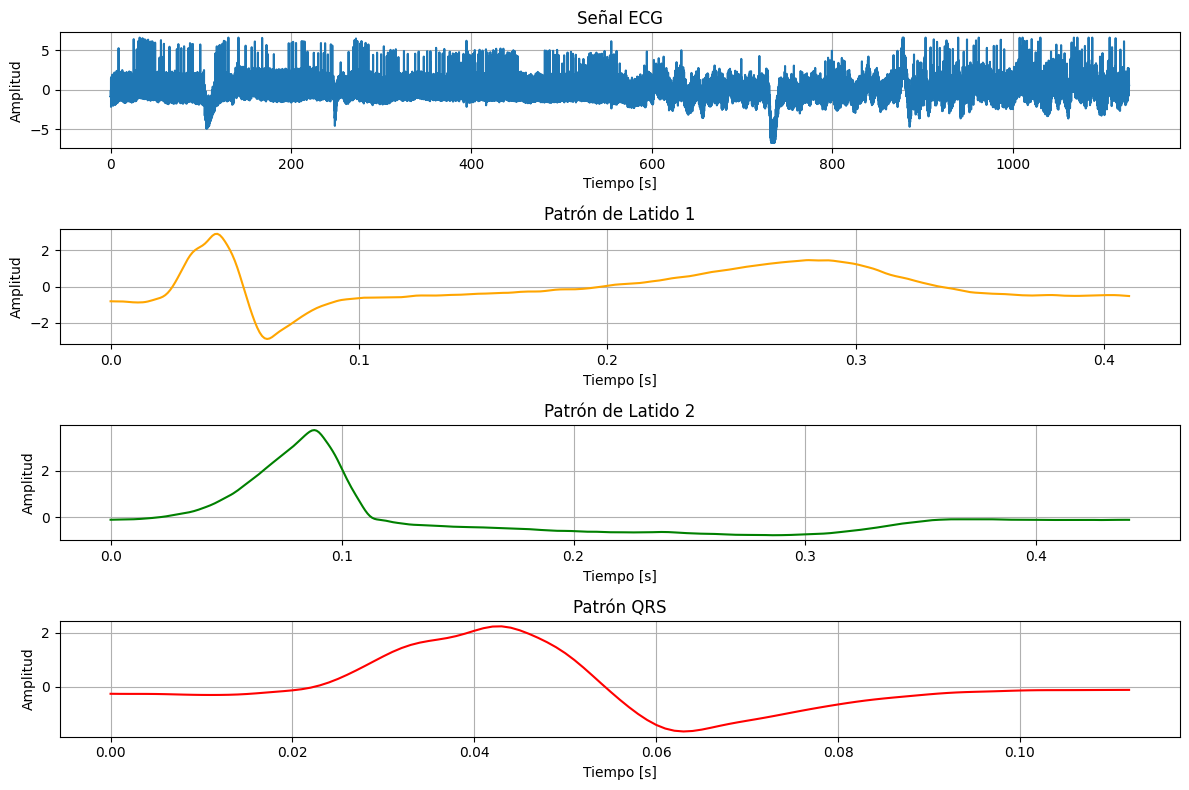

In [2]:


# Cargar la señal ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs = mat_struct['qrs_pattern1'].flatten()

# Normalización tipo z-score: (x - media) / std
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Aplicar normalización
ecg = normalize(ecg)
hb1 = normalize(hb1)
hb2 = normalize(hb2)
qrs = normalize(qrs)

# Crear un vector de tiempo para la señal ECG completa
t_ecg = np.arange(len(ecg)) / fs_ecg

# Crear vectores de tiempo para los patrones (usualmente de menor duración)
t_hb1 = np.arange(len(hb1)) / fs_ecg
t_hb2 = np.arange(len(hb2)) / fs_ecg
t_qrs = np.arange(len(qrs)) / fs_ecg

# Graficar
plt.figure(figsize=(12, 8))

# Señal ECG completa
plt.subplot(4, 1, 1)
plt.plot(t_ecg, ecg, label='ECG Lead')
plt.title('Señal ECG')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)

# Patrón Heartbeat 1
plt.subplot(4, 1, 2)
plt.plot(t_hb1, hb1, label='Heartbeat Pattern 1', color='orange')
plt.title('Patrón de Latido 1')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)

# Patrón Heartbeat 2
plt.subplot(4, 1, 3)
plt.plot(t_hb2, hb2, label='Heartbeat Pattern 2', color='green')
plt.title('Patrón de Latido 2')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)

# Patrón QRS
plt.subplot(4, 1, 4)
plt.plot(t_qrs, qrs, label='QRS Pattern', color='red')
plt.title('Patrón QRS')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid(True)

plt.tight_layout()
plt.show()


In [3]:
%matplotlib qt
# Correlación cruzada (modo 'valid' para evitar bordes con poco solapamiento)
corr = np.correlate(ecg, qrs, mode='same')

# Crear vector de tiempo para la correlación
fs_ecg = 1000  # Hz
t_corr = np.arange(len(corr)) / fs_ecg

# Graficar la correlación
plt.figure(figsize=(10, 4))
plt.plot(t_corr, corr, label='Correlación cruzada ECG-QRS')

plt.title('Correlación cruzada entre ECG y patrón QRS')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficiente de correlación')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:

# Detectar picos
# Parámetros recomendados:
# - height: umbral mínimo (por ejemplo, 50% del máximo)
# - distance: separación mínima entre picos (en muestras)
peaks, properties = find_peaks(corr,height=30, distance=250)  # ~250 ms si fs = 1000 Hz

# Crear vector de tiempo para la correlación
fs = 1000  # Hz
t_corr = np.arange(len(corr)) / fs

# Graficar correlación con los picos
plt.figure(figsize=(10, 4))
plt.plot(t_corr, corr, label='Correlación ECG - QRS')
plt.plot(t_corr, ecg, label='ECG')
plt.plot(t_corr[peaks], corr[peaks], 'rx', label='Picos detectados')
plt.title('Picos de correlación (posibles latidos)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Correlación')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Graficar el histograma
plt.figure(figsize=(8, 4))
plt.hist(peaks, bins=60, color='skyblue', edgecolor='black')
plt.title('Histograma de la correlación cruzada ECG-QRS')
plt.xlabel('Valor de correlación')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show() 

In [10]:



# Ventana: 100 ms antes y 300 ms después del pico
fs = 1000  # Hz
pre = int(0.2 * fs)   # 100 muestras antes
post = int(0.3 * fs)  # 300 muestras después

latidos = []

for peak in peaks:
    center = peak + len(qrs)//2  # corregir desfase por correlación
    start = center - pre
    end = center + post
    if start >= 0 and end <= len(ecg):
        latido = ecg[start:end]
        latidos.append(latido)

latidos = np.array(latidos)
template_latido = np.mean(latidos, axis=0)

# Vector de tiempo para la ventana (en segundos)
t_latido = np.linspace(-0.1, 0.3, pre + post)  # de -100 ms a +300 ms

# Graficar
plt.figure(figsize=(10, 5))
for l in latidos[:60]:  # mostrar algunos latidos individuales
    plt.plot(t_latido, l, color='gray', alpha=0.3)
plt.plot(t_latido, template_latido, color='red', linewidth=2, label='Latido promedio')
plt.title('Promedio de latidos (100 ms antes, 300 ms después del pico)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud normalizada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()